In [1]:
import pandas as pd
import string
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [39]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score
import gensim.downloader as api
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l2


In [4]:
df_test = pd.read_csv('../raw_data/titles_data/titles_test_trnls.csv')
df_train = pd.read_csv('../raw_data/titles_data/titles_train_trnls.csv')

In [5]:
df_train.head(10)

,Image_name,Title,translated_title
0,1588345297.jpg,"Colet example, and SA sported ronals Gentl Twi...","Colet example, and SA sported ronals Gentl Twi..."
1,1404803335.jpg,Maghets Pulling Together Pushing Apart,Maghets Pulling Together Pushing Apart
2,1446276082.jpg,ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...,ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...
3,1491522666.jpg,AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...,AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...
4,0970096410.jpg,City of Rocks Idaho A Climber's Guide untale,City of Rocks Idaho A Climber's Guide untale
5,8436808053.jpg,CÓMO VENCER EL INSOMNIO MARIANO CHOLIZ MONTANE...,HOW TO BEAT INSOMNIA MARIANO CHOLIZ MONTANES T...
6,1848291388.jpg,JOHN MARTIN LITTLEJOHN by John Den AN ENIGMA O...,JOHN MARTIN LITTLEJOHN by John Den AN ENIGMA O...
7,0073402656.jpg,CH EMISTRY De Molar ata Silberberg,CH EMISTRY De Molar ata Silberberg
8,0323045979.jpg,Mosby's ONCOLOGY NURSING ADVISOR A Comprehensi...,Mosby's ONCOLOGY NURSING ADVISOR A Comprehensi...
9,1847176968.jpg,IRELAND'S WILD ATLANTIC WAY Carsten Krieger,IRELAND'S WILD ATLANTIC WAY Carsten Krieger


In [6]:
df_test

,Image_name,Title,translated_title
0,044310073X.jpg,Sereed Camion Oral and Maxillofacial Surgery A...,Sereed Camion Oral and Maxillofacial Surgery A...
1,1438005687.jpg,BARRON'S The Leader in Test Preparation GRE MO...,BARRON'S The Leader in Test Preparation GRE MO...
2,0060750715.jpg,The Ballet Maker wwww. George Balanchine Rober...,The Ballet Maker wwww. George Balanchine Rober...
3,1580237959.jpg,INSTITUTE FOR JEWISH SPIRITUALITY SERIES A PAR...,INSTITUTE FOR JEWISH SPIRITUALITY SERIES A PAR...
4,0135137829.jpg,Tu Oce P and P and Co acred Construction Sched...,Tu Oce P and P and Co acred Construction Sched...
...,...,...,...
5695,0399174680.jpg,#1 NEW YORK TIMES BESTSELLING AUTHOR STUART WO...,#1 NEW YORK TIMES BESTSELLING AUTHOR STUART WO...
5696,1939454654.jpg,STORIES FROM THE AGE OF DISTRACTION VOLUME ONE...,STORIES FROM THE AGE OF DISTRACTION VOLUME ONE...
5697,1604601604.jpg,Fifth Moved in the Culasidge Community Series ...,Fifth Moved in the Culasidge Community Series ...
5698,0399166726.jpg,WX -LIBA Saving Jason MICHAEL SEARS BLACK FRIDAYS,WX -LIBA Saving Jason MICHAEL SEARS BLACK FRIDAYS


In [7]:
def preprocessed_title(titles):
    output = titles.str.lower()
    output = output.apply(lambda x: "".join([i for i in x if i not in string.punctuation]))
    output = output.apply(lambda x: "".join([i for i in x if i not in string.digits]))
    output = output.apply(lambda x: re.split('\W+', x))
    #output = output.apply(lambda x: [str(TextBlob(word).correct()) for word in x])
    porter_stemmer = PorterStemmer()
    output = output.apply(lambda x: [porter_stemmer.stem(word) for word in x])
    stops = set(stopwords.words('english'))
    output = output.apply(lambda x: [word for word in x if word not in stops])

    return output

In [8]:
X_train_preproc = preprocessed_title(df_train['translated_title'].fillna(''))

In [9]:
X_test_preproc = preprocessed_title(df_test['translated_title'].fillna(''))

In [10]:
X_train_preproc.head(10)

0    [colet, exampl, sa, sport, ronal, gentl, twitt...
1                  [maghet, pull, togeth, push, apart]
2    [energi, secur, volum, sage, librari, intern, ...
3    [audiobook, mpcd, insert, transfer, listen, tr...
4            [citi, rock, idaho, climber, guid, untal]
5    [beat, insomnia, mariano, choliz, montan, tech...
6    [john, martin, littlejohn, john, den, enigma, ...
7            [ch, emistri, de, molar, ata, silberberg]
8    [mosbi, oncolog, nurs, advisor, comprehens, gu...
9       [ireland, wild, atlant, way, carsten, krieger]
Name: translated_title, dtype: object

## Word2vec - trained directly on our text/titles

In [126]:
!pip freeze | grep gensim

gensim==4.2.0


In [127]:
!pip freeze | grep tensorflow

tensorflow==2.13.0rc1
tensorflow-datasets==4.6.0
tensorflow-estimator==2.13.0rc0
tensorflow-macos==2.13.0rc1
tensorflow-metadata==1.10.0


In [11]:
len(X_train_preproc)

51300

In [12]:
word2vec = Word2Vec(sentences=X_train_preproc, min_count=5, vector_size=50, window=10) 
#wv = word2vec.wv

In [13]:
print(word2vec.wv['leadership'])


[ 0.14625393 -0.15633479  0.05557967  0.34217998 -0.39259875 -0.13341148
  0.6950069   0.84173465 -0.5545711  -0.06755563 -0.12421155 -0.6892816
 -0.31067204  0.10473539 -0.17852193  0.04898529  0.02054812 -0.3389984
 -0.6115213  -0.26562506 -0.3117744   0.3318919   0.45860493 -0.4419167
  0.26931283  0.1371435  -0.6327363  -0.39137724 -0.2663633  -0.0477081
  0.07058789  0.02037158  0.25071052  0.39494672 -0.3041949   0.18948676
 -0.13517971 -0.0467443   0.02604167 -0.23469375  0.4165158  -0.21385121
 -0.21400122 -0.00839926  0.11302004 -0.13248836 -0.50776213 -0.04233142
  0.23058195  0.61187404]


In [14]:
word2vec.wv.most_similar('crime')

[('black', 0.967535674571991),
 ('fiction', 0.960634708404541),
 ('sherlock', 0.9599357843399048),
 ('origin', 0.9524857401847839),
 ('white', 0.9493749141693115),
 ('scalzi', 0.9410486221313477),
 ('legend', 0.9401237368583679),
 ('rise', 0.9365515112876892),
 ('jedi', 0.9359537959098816),
 ('dagger', 0.9357104301452637)]

In [15]:
word2vec.wv.vectors.shape

(12470, 50)

In [16]:
# Functions to return list of embedded sentences (each sentence as a matrix)

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [17]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train_preproc)
X_test_embed = embedding(word2vec, X_test_preproc)

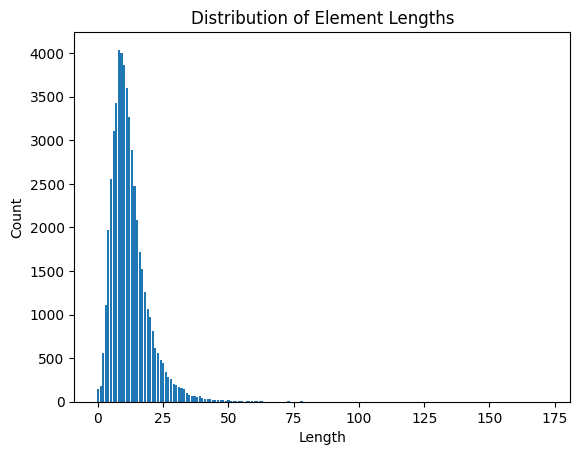

In [18]:
# Count the lengths of elements in the list
lengths = [len(element) for element in X_train_preproc]
length_counts = Counter(lengths)

# Extract the lengths and counts for plotting
x = list(length_counts.keys())
y = list(length_counts.values())

# Plot the bar graph
plt.bar(x, y)
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution of Element Lengths')
plt.show()

In [19]:
len(max(X_train_preproc, key=len))

172

In [20]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=100)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=100)

In [21]:
# TEST ME
for X in [X_train_pad, X_test_pad]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.wv.vector_size


assert X_train_pad.shape[0] == len(X_train_preproc)
assert X_test_pad.shape[0] == len(X_test_preproc)

### y target preperoc

In [22]:
y_train = np.load('../raw_data/tmp_data/train_y_prep.npy', encoding='bytes', allow_pickle=True)
# shape (51300, 30)

In [23]:
y_test = np.load('../raw_data/tmp_data/test_y_prep.npy', encoding='bytes', allow_pickle=True)
# shape (5700, 30)

In [24]:
print(X_train_pad.shape, y_train.shape)
print(X_test_pad.shape, y_test.shape)

(51300, 100, 50) (51300, 30)
(5700, 100, 50) (5700, 30)


In [25]:
y_train_umbr = np.load("../raw_data/tmp_data/y_train_umbr.npy", encoding='bytes', allow_pickle=True)
y_train_umbr_df = pd.DataFrame(y_train_umbr)
y_train_umbr_df = y_train_umbr_df.rename(columns={
    y_train_umbr_df.columns[0]: 'Genre_id',
    y_train_umbr_df.columns[1]: 'Genre_name',
    y_train_umbr_df.columns[2]: 'Genre_umbr_name',
    y_train_umbr_df.columns[3]: 'Genre_umbr_id'
})

#y_umbr = y_umbr.rename_axis('Genre_id')
y_train_umbr_df['Genre_umbr_id'] = y_train_umbr_df['Genre_umbr_id'] - 1
y_train_umbr_df

,Genre_id,Genre_name,Genre_umbr_name,Genre_umbr_id
0,1,Biographies & Memoirs,History & Religion,0
1,4,Children's Books,Relationships & Children,1
2,10,Engineering & Transportation,Academic - Science,2
3,9,Christian Books & Bibles,History & Religion,0
4,26,Sports & Outdoors,Lifestyle & Fitness,3
...,...,...,...,...
51295,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
51296,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
51297,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
51298,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4


In [26]:
y_umbr_test = np.load("../raw_data/tmp_data/y_test_umbr.npy", encoding='bytes', allow_pickle=True)
y_umbr_test_df = pd.DataFrame(y_umbr_test)
y_umbr_test_df = y_umbr_test_df.rename(columns={
    y_umbr_test_df.columns[0]: 'Genre_id',
    y_umbr_test_df.columns[1]: 'Genre_name',
    y_umbr_test_df.columns[2]: 'Genre_umbr_name',
    y_umbr_test_df.columns[3]: 'Genre_umbr_id'
})

#y_umbr = y_umbr.rename_axis('Genre_id')
y_umbr_test_df['Genre_umbr_id'] = y_umbr_test_df['Genre_umbr_id'] - 1
y_umbr_test_df

,Genre_id,Genre_name,Genre_umbr_name,Genre_umbr_id
0,16,Medical Books,Academic - Science,2
1,28,Test Preparation,Academic - Pure,7
2,1,Biographies & Memoirs,History & Religion,0
3,21,Religion & Spirituality,History & Religion,0
4,0,Arts & Photography,Arts & Hobbies,6
...,...,...,...,...
5695,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
5696,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
5697,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
5698,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4


In [27]:
y_train_umbr = y_train_umbr_df['Genre_umbr_id'].astype(int)
y_test_umbr = y_umbr_test_df['Genre_umbr_id'].astype(int)
print(y_train_umbr.shape, y_test_umbr.shape)
print(len(np.unique(y_train_umbr)))

(51300,) (5700,)
8


In [28]:
y_train_umbr -= 1
y_train_umbr = to_categorical(y_train_umbr, num_classes=8)

In [29]:
y_test_umbr -= 1
y_test_umbr = to_categorical(y_test_umbr, num_classes=8)

In [30]:
print(X_train_pad.shape, y_train.shape)
print(X_test_pad.shape, y_test.shape)

(51300, 100, 50) (51300, 30)
(5700, 100, 50) (5700, 30)


In [31]:
print(X_train_pad.shape, y_train_umbr.shape)
print(X_test_pad.shape, y_test_umbr.shape)

(51300, 100, 50) (51300, 8)
(5700, 100, 50) (5700, 8)


### Plot function

In [35]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

## Model RNN (word2vec trained on our text)

### 30 categories

In [74]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(50, activation='tanh'))
    model.add(layers.Dropout(0.2))  
    #model.add(layers.LSTM(25, activation='tanh'))
    #model.add(layers.Dropout(0.2))  
    model.add(layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.Dense(30, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [75]:
X_train_pad.shape

(51300, 100, 50)

In [76]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.2,
          callbacks=[es]
         )

Epoch 1/100
1283/1283 [==============================] - 34s 25ms/step - loss: 2.9515 - accuracy: 0.1809 - val_loss: 3.0042 - val_accuracy: 0.1505
Epoch 2/100
1283/1283 [==============================] - 31s 24ms/step - loss: 2.7033 - accuracy: 0.2417 - val_loss: 2.9442 - val_accuracy: 0.1529
Epoch 3/100
1283/1283 [==============================] - 32s 25ms/step - loss: 2.6257 - accuracy: 0.2617 - val_loss: 2.8775 - val_accuracy: 0.1733
Epoch 4/100
1283/1283 [==============================] - 32s 25ms/step - loss: 2.5739 - accuracy: 0.2731 - val_loss: 2.8149 - val_accuracy: 0.1757
Epoch 5/100
1283/1283 [==============================] - 33s 25ms/step - loss: 2.5335 - accuracy: 0.2824 - val_loss: 2.8709 - val_accuracy: 0.1767
Epoch 6/100
1283/1283 [==============================] - 31s 24ms/step - loss: 2.5017 - accuracy: 0.2894 - val_loss: 2.7639 - val_accuracy: 0.1950
Epoch 7/100
1283/1283 [==============================] - 31s 24ms/step - loss: 2.4708 - accuracy: 0.2986 - val_loss: 2

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

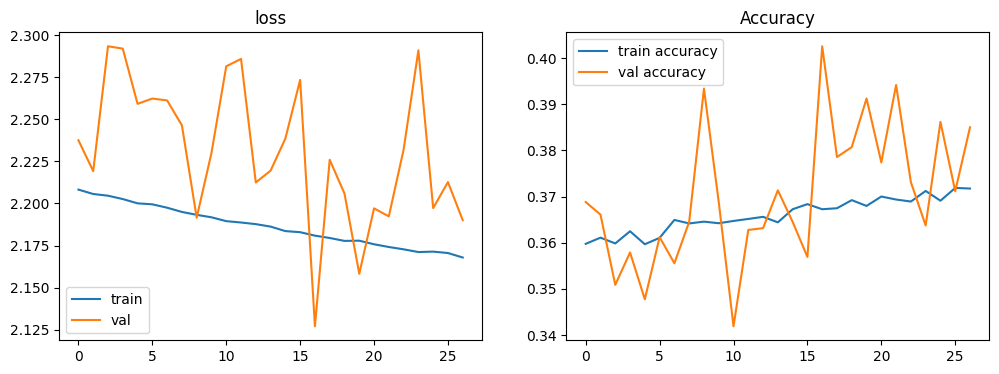

In [182]:
#plot_history(history)  # first model learning curves (rmsprop, batch 32, val split 0.1)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

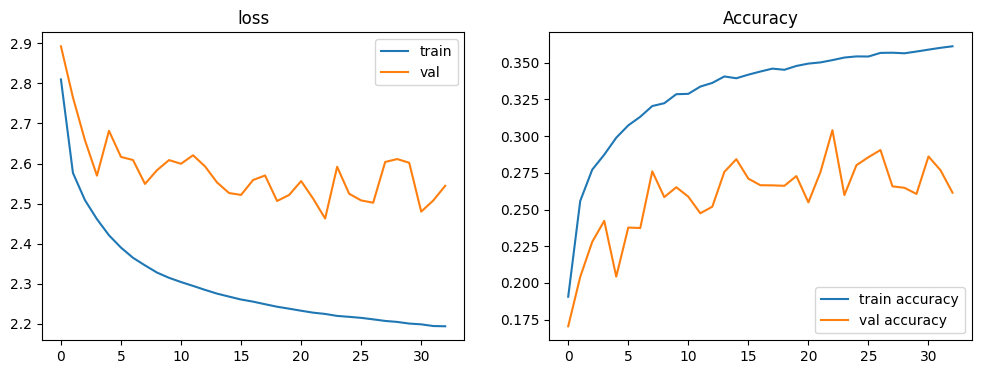

In [36]:
#plot_history(history) # plot history with adam, batch 16, valid.split 0.2 (no dropout or reguraliser)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

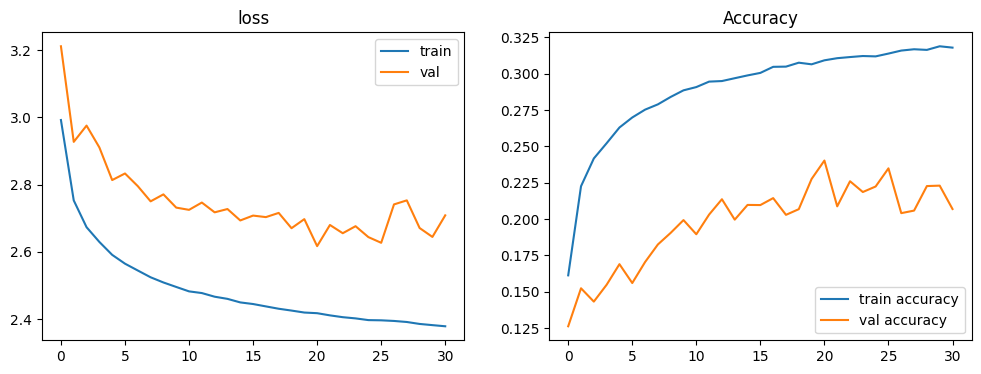

In [42]:
#plot_history(history) # plot like above + dropout and reguraliser

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

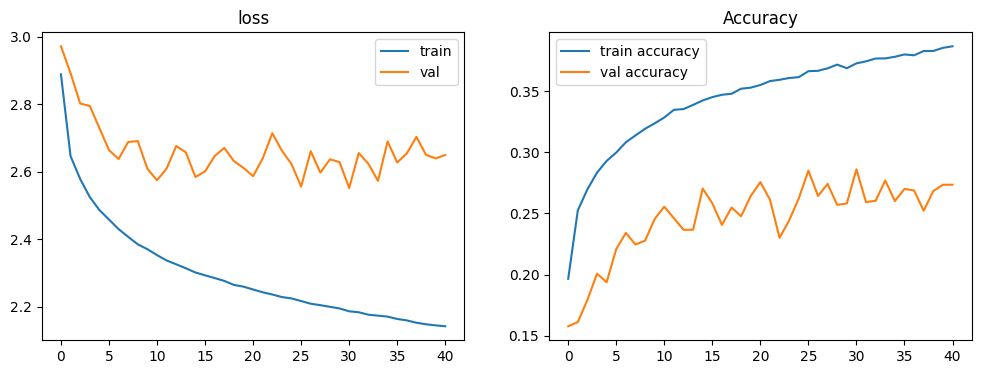

In [68]:
#plot_history(history) # above, but with lstm 50

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

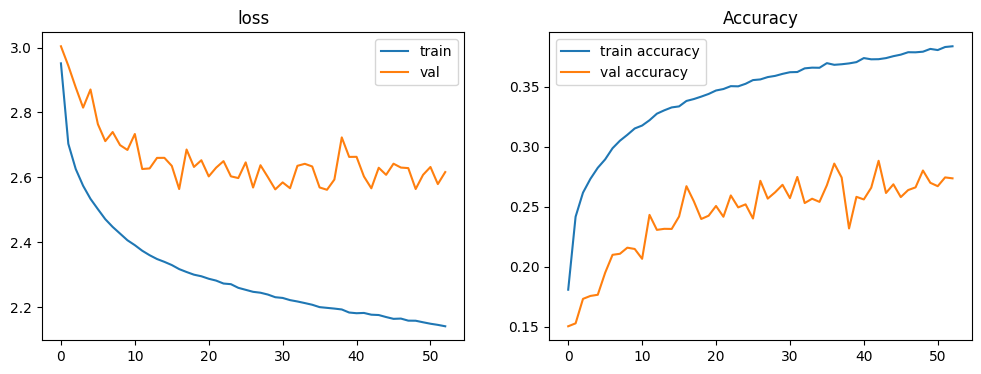

In [77]:
plot_history(history) # above, lstm 50 and batch 32 (not 16)

In [78]:
res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 32.298%


In [81]:
y_pred_full = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 2s 6ms/step


In [82]:
y_test_or = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']
y_test_or

Id
0       16
1       28
2        1
3       21
4        0
        ..
5695    17
5696    17
5697    17
5698    17
5699    17
Name: Genre_id, Length: 5700, dtype: int64

In [83]:
top_k_accuracy = top_k_accuracy_score(y_test_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 54.11%


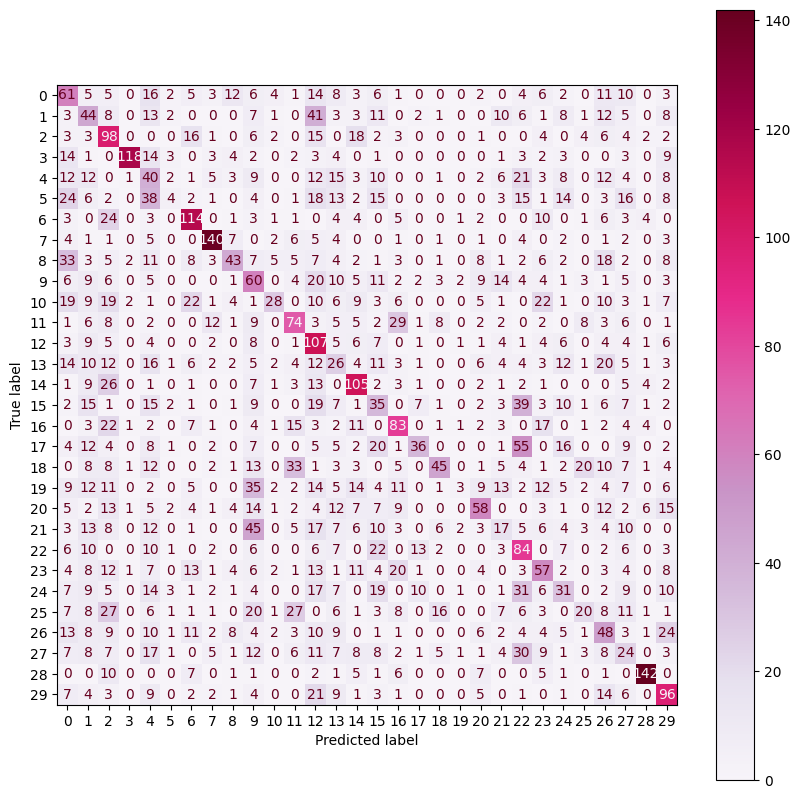

In [84]:
cm = confusion_matrix(y_test_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

### 8 categories


In [88]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(50, activation='tanh'))
    model.add(layers.Dropout(0.2))  
    #model.add(layers.LSTM(25, activation='tanh'))
    #model.add(layers.Dropout(0.2))  
    model.add(layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [89]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(X_train_pad, y_train_umbr, 
          batch_size = 32,
          epochs=100,
          validation_split=0.2,
          callbacks=[es]
         )

Epoch 1/100
1283/1283 [==============================] - 34s 24ms/step - loss: 1.6974 - accuracy: 0.4144 - val_loss: 1.7362 - val_accuracy: 0.4143
Epoch 2/100
1283/1283 [==============================] - 31s 24ms/step - loss: 1.5441 - accuracy: 0.4578 - val_loss: 1.5236 - val_accuracy: 0.4996
Epoch 3/100
1283/1283 [==============================] - 31s 24ms/step - loss: 1.5001 - accuracy: 0.4728 - val_loss: 1.4942 - val_accuracy: 0.5362
Epoch 4/100
1283/1283 [==============================] - 31s 24ms/step - loss: 1.4724 - accuracy: 0.4817 - val_loss: 1.4930 - val_accuracy: 0.4992
Epoch 5/100
1283/1283 [==============================] - 30s 23ms/step - loss: 1.4508 - accuracy: 0.4857 - val_loss: 1.4496 - val_accuracy: 0.5288
Epoch 6/100
1283/1283 [==============================] - 30s 23ms/step - loss: 1.4318 - accuracy: 0.4948 - val_loss: 1.4197 - val_accuracy: 0.5404
Epoch 7/100
1283/1283 [==============================] - 29s 23ms/step - loss: 1.4183 - accuracy: 0.5022 - val_loss: 1

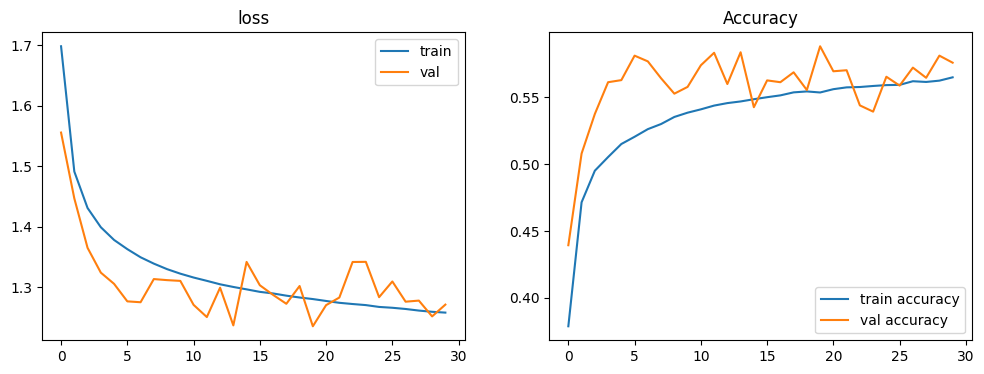

In [240]:
#plot_history(history); #first model learning curves (rmsprop, batch 32, val split 0.1)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

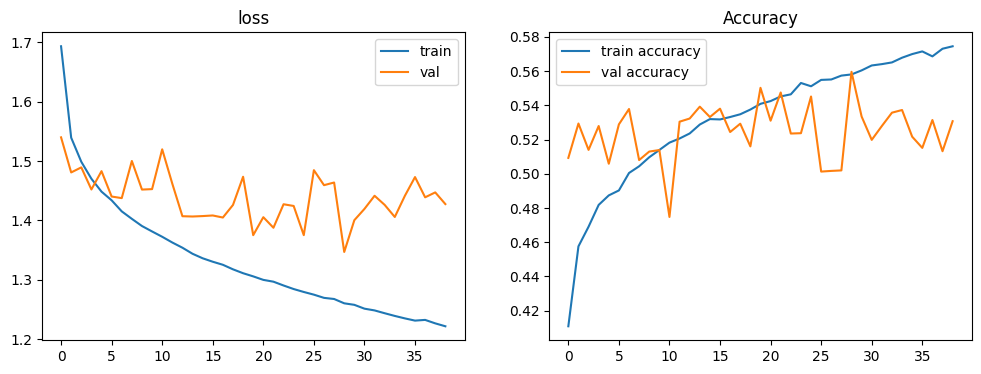

In [87]:
# plot history with adam, batch 32, val split 0.2, dropout layer, reguralisation and lstm 50
#plot_history(history)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

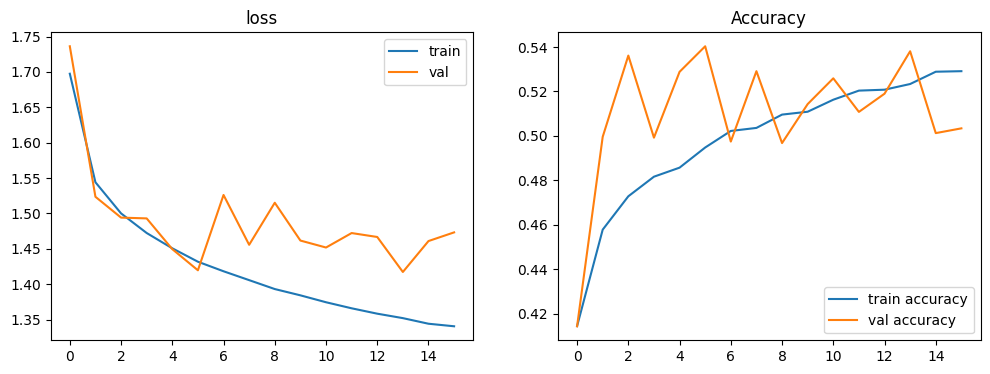

In [90]:
# same as above with rmsprop
plot_history(history)

In [91]:
res = model.evaluate(X_test_pad, y_test_umbr, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 49.877%


In [92]:
y_pred_full = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 2s 6ms/step


In [94]:
y_pred

array([1, 6, 2, ..., 1, 7, 3])

In [96]:
y_test_umbr_or = y_umbr_test_df['Genre_umbr_id'].astype(int)
y_test_umbr_or

0       2
1       7
2       0
3       0
4       6
       ..
5695    4
5696    4
5697    4
5698    4
5699    4
Name: Genre_umbr_id, Length: 5700, dtype: int64

In [97]:
top_k_accuracy = top_k_accuracy_score(y_test_umbr_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 27.25%


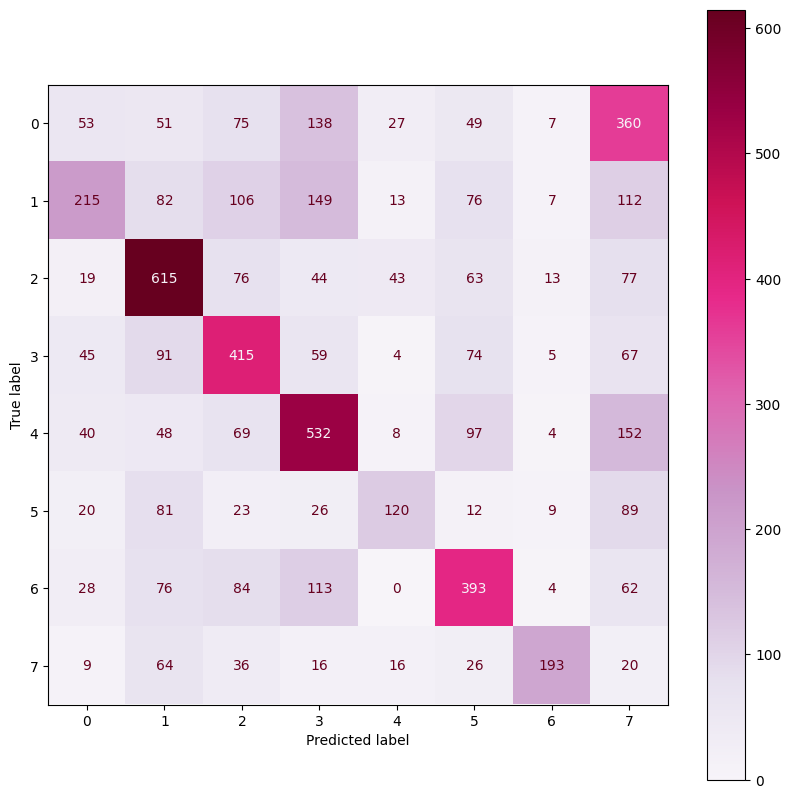

In [98]:
cm = confusion_matrix(y_test_umbr_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

## Model RNN (word2vec pre-trained)


In [248]:
# Load a Word2Vec embedding
word2vec_transfer = api.load("glove-wiki-gigaword-50")

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [249]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec_transfer, X_train_preproc)
X_test_embed = embedding(word2vec_transfer, X_test_preproc)

In [250]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=100)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=100)

### 30 categories


In [212]:
X_train_pad.shape

(51300, 100, 50)

In [213]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(30, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [214]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )

Epoch 1/100
1443/1443 [==============================] - 29s 18ms/step - loss: 3.0144 - accuracy: 0.1519 - val_loss: 3.0123 - val_accuracy: 0.1380
Epoch 2/100
1443/1443 [==============================] - 25s 17ms/step - loss: 2.6179 - accuracy: 0.2575 - val_loss: 2.7332 - val_accuracy: 0.2138
Epoch 3/100
1443/1443 [==============================] - 24s 17ms/step - loss: 2.4873 - accuracy: 0.2948 - val_loss: 2.5343 - val_accuracy: 0.2877
Epoch 4/100
1443/1443 [==============================] - 26s 18ms/step - loss: 2.4247 - accuracy: 0.3117 - val_loss: 2.5274 - val_accuracy: 0.2729
Epoch 5/100
1443/1443 [==============================] - 25s 17ms/step - loss: 2.3819 - accuracy: 0.3256 - val_loss: 2.5538 - val_accuracy: 0.2692
Epoch 6/100
1443/1443 [==============================] - 25s 18ms/step - loss: 2.3509 - accuracy: 0.3323 - val_loss: 2.4238 - val_accuracy: 0.3359
Epoch 7/100
1443/1443 [==============================] - 26s 18ms/step - loss: 2.3270 - accuracy: 0.3394 - val_loss: 2

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

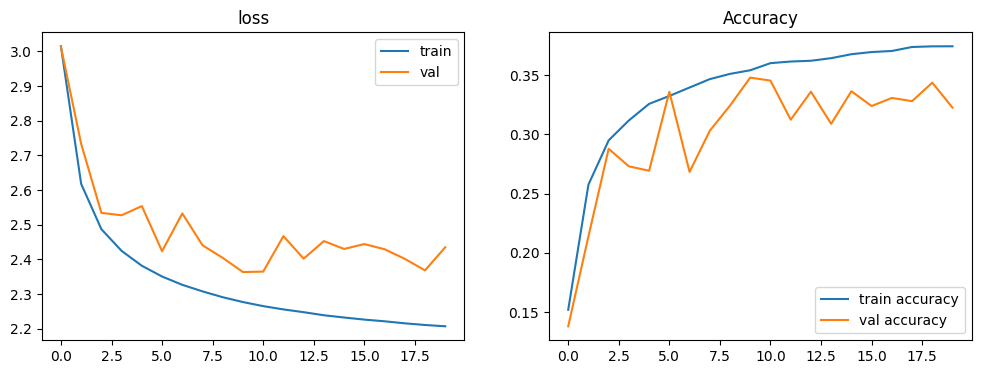

In [215]:
plot_history(history)

In [216]:
res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 32.737%


In [217]:
y_pred_full = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 1s 4ms/step


In [224]:
y_test_or = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']

In [225]:
top_k_accuracy = top_k_accuracy_score(y_test_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 54.16%


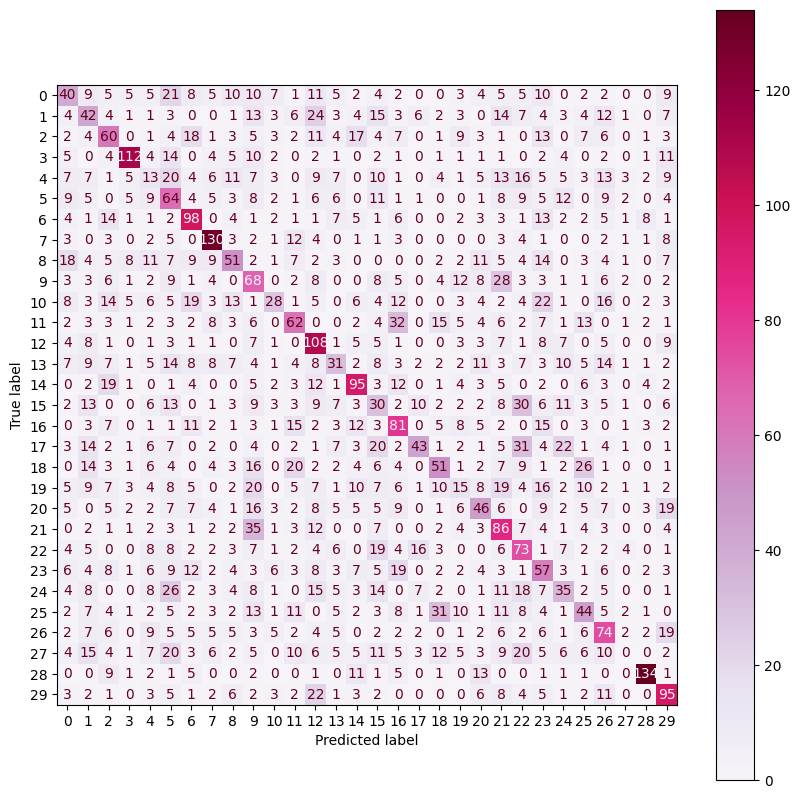

In [226]:
cm = confusion_matrix(y_test_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

### 8 categories

In [251]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [252]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(X_train_pad, y_train_umbr, 
          batch_size = 32,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )


Epoch 1/100
1443/1443 [==============================] - 29s 18ms/step - loss: 1.7173 - accuracy: 0.3780 - val_loss: 1.5578 - val_accuracy: 0.4561
Epoch 2/100
1443/1443 [==============================] - 26s 18ms/step - loss: 1.5029 - accuracy: 0.4675 - val_loss: 1.4404 - val_accuracy: 0.4881
Epoch 3/100
1443/1443 [==============================] - 25s 17ms/step - loss: 1.4380 - accuracy: 0.4934 - val_loss: 1.3384 - val_accuracy: 0.5347
Epoch 4/100
1443/1443 [==============================] - 25s 18ms/step - loss: 1.4027 - accuracy: 0.5075 - val_loss: 1.3802 - val_accuracy: 0.5177
Epoch 5/100
1443/1443 [==============================] - 25s 17ms/step - loss: 1.3785 - accuracy: 0.5165 - val_loss: 1.3540 - val_accuracy: 0.5310
Epoch 6/100
1443/1443 [==============================] - 25s 17ms/step - loss: 1.3608 - accuracy: 0.5214 - val_loss: 1.3576 - val_accuracy: 0.5320
Epoch 7/100
1443/1443 [==============================] - 24s 17ms/step - loss: 1.3474 - accuracy: 0.5277 - val_loss: 1

In [254]:
y_test_umbr_or

0       2
1       7
2       0
3       0
4       6
       ..
5695    4
5696    4
5697    4
5698    4
5699    4
Name: Genre_umbr_id, Length: 5700, dtype: int64

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

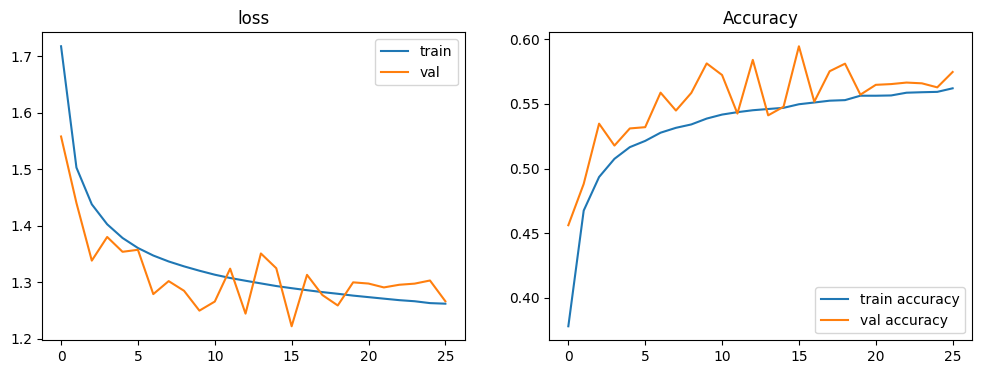

In [255]:
plot_history(history)

In [256]:
res = model.evaluate(X_test_pad, y_test_umbr, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 52.193%


In [257]:
y_pred_full = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 1s 4ms/step


In [258]:
top_k_accuracy = top_k_accuracy_score(y_test_umbr_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 25.37%


0       2
1       7
2       0
3       0
4       6
       ..
5695    4
5696    4
5697    4
5698    4
5699    4
Name: Genre_umbr_id, Length: 5700, dtype: int64

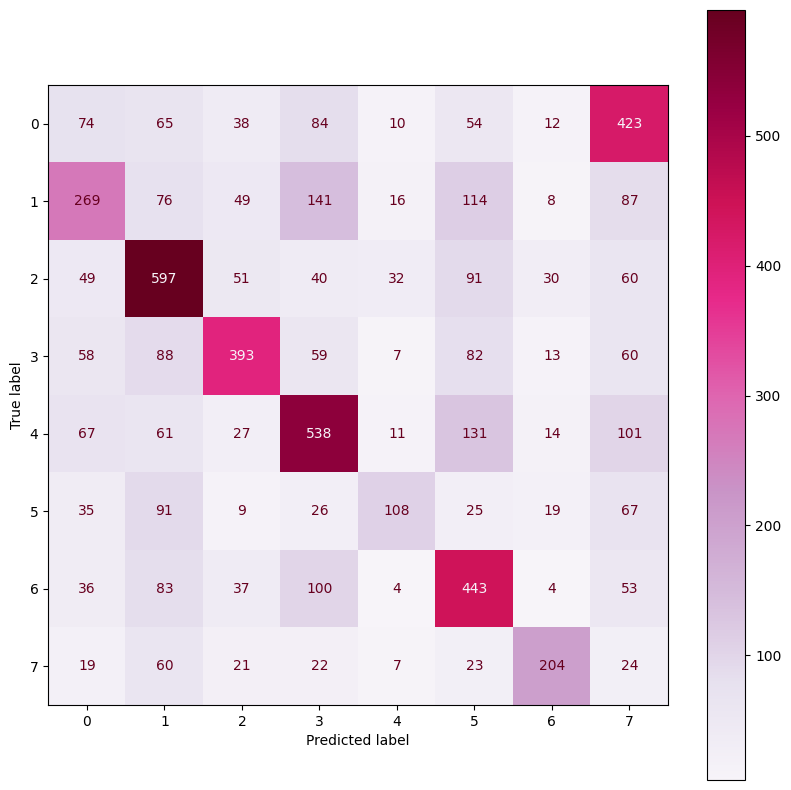

In [261]:
cm = confusion_matrix(y_test_umbr_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)